In [554]:
import pandas as pd
import numpy as np
import plotly.io as pio
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import matplotlib.patches
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from math import sqrt
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2
import pmdarima as pm
from os import listdir
import warnings

warnings.filterwarnings('ignore')

In [555]:
def plot_hbar(df, x, y, title):
    fig = px.bar(df, 
                 x=x, y=y, 
                 text=x, orientation='v', width=700, color = x)
    fig.update_layout(title=title, xaxis_title=x, yaxis_title=y,
                      uniformtext_minsize=8, uniformtext_mode='hide')
    fig.show()


In [556]:
dfs = pd.read_csv('df.csv').drop(columns = 'Unnamed: 0')

In [557]:
dfs.head(5)

,tramite_fecha,registro_seccional_provincia,count
0,2018-09-14,Córdoba,858
1,2018-09-28,Entre Ríos,268
2,2018-09-07,Mendoza,423
3,2018-09-04,Río Negro,152
4,2018-09-20,Catamarca,43


In [558]:
df = dfs.pivot_table(index='tramite_fecha',
               columns='registro_seccional_provincia',
               values='count',
               fill_value=0)

df.columns.name = None              

df = df.loc[:,~df.apply(lambda x: x.duplicated(),axis=1).all()].copy()

In [559]:
df["sum"] = df[df.columns[1:]].sum(axis=1)

In [560]:
df["sum"].describe()

count    1315.000000
mean     3536.034981
std      1757.163498
min         0.000000
25%      3727.000000
50%      4277.000000
75%      4605.500000
max      5633.000000
Name: sum, dtype: float64

In [561]:
from pandas.tseries.offsets import BDay
isBusinessDay = BDay().onOffset

df['tramite_fecha'] = df.index
df["tramite_fecha"] = pd.to_datetime(df["tramite_fecha"])


match_series = pd.to_datetime(df['tramite_fecha']).map(isBusinessDay)
df = df[(df['Ciudad Autónoma de Bs.As.']>= 1) & (df['Córdoba']>= 1)]
df = df[match_series]


df_copy = df.copy()

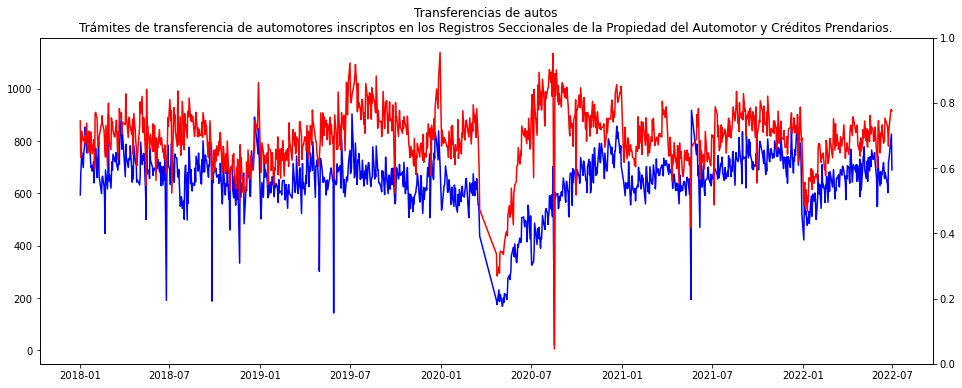

In [562]:
import pandas as pd 
import matplotlib.pyplot as plt 
plt.rcParams["figure.figsize"] = (16,6)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(df_copy['tramite_fecha'], df_copy['Ciudad Autónoma de Bs.As.'], label="Ciudad Autónoma de Bs.As.",  c="b");
ax1.plot(df_copy['tramite_fecha'], df_copy['Córdoba'], label="Córdoba",  c="r");

plt.title('Transferencias de autos\nTrámites de transferencia de automotores inscriptos en los Registros Seccionales de la Propiedad del Automotor y Créditos Prendarios.')
plt.show()

In [563]:
df.tramite_fecha

tramite_fecha
2018-01-02   2018-01-02
2018-01-03   2018-01-03
2018-01-04   2018-01-04
2018-01-05   2018-01-05
2018-01-08   2018-01-08
                ...    
2022-06-23   2022-06-23
2022-06-24   2022-06-24
2022-06-28   2022-06-28
2022-06-29   2022-06-29
2022-06-30   2022-06-30
Name: tramite_fecha, Length: 1069, dtype: datetime64[ns]

In [564]:
df['año']     = pd.DatetimeIndex(df['tramite_fecha']).year
df['mes_año'] = pd.to_datetime(df['tramite_fecha']).dt.to_period('M')
df.head(5)

,Buenos Aires,Catamarca,Chaco,Chubut,Ciudad Autónoma de Bs.As.,Corrientes,Córdoba,Entre Ríos,Formosa,Jujuy,...,San Luis,Santa Cruz,Santa Fe,Santiago del Estero,Tierra del Fuego,Tucumán,sum,tramite_fecha,año,mes_año
tramite_fecha,,,,,,,,,,,,,,,,,,,,,
2018-01-02,2719,43,94,145,594,178,877,271,44,58,...,106,70,724,74,39,157,4666,2018-01-02,2018,2018-01
2018-01-03,2809,45,141,134,672,184,737,285,42,70,...,112,49,623,51,41,167,4577,2018-01-03,2018,2018-01
2018-01-04,2857,30,121,139,714,157,760,286,43,65,...,110,81,689,68,50,182,4773,2018-01-04,2018,2018-01
2018-01-05,2884,46,122,162,757,179,838,300,56,71,...,116,72,643,71,55,149,4912,2018-01-05,2018,2018-01
2018-01-08,2711,35,130,165,699,162,803,293,47,51,...,71,62,641,85,39,137,4682,2018-01-08,2018,2018-01


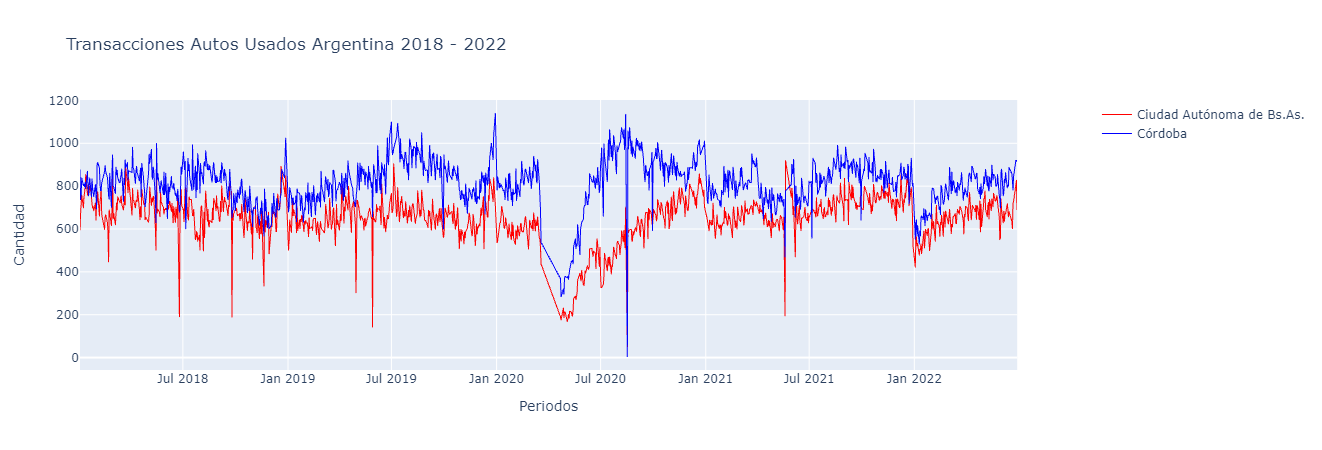

In [565]:
from plotly.subplots import make_subplots
def get_line_plot(dataframe, x, y1, y2, titulo):
    subfig = make_subplots(specs=[[{"secondary_y": True}]])

    fig  = px.line(dataframe, x=x, y=y1)

    fig2 = px.line(dataframe, x=x,y=y2)

    fig.update_layout(xaxis_rangeslider_visible=True)
    fig.update_traces(showlegend=True,name=y1,line_color='red', line_width=1)
    fig2.update_traces(showlegend=True,name=y2,line_color='#0000ff', line_width=1) #, yaxis="y2"
    subfig.add_traces(fig.data + fig2.data)

    subfig.layout.xaxis.title ="Periodos"
    subfig.layout.yaxis.title ="Cantidad"
    subfig.layout.yaxis2.title="Cantidad"
    subfig.layout.title=titulo 

    return subfig.show()

get_line_plot(df_copy, "tramite_fecha", "Ciudad Autónoma de Bs.As.", "Córdoba", "Transacciones Autos Usados Argentina 2018 - 2022")

In [566]:
df_copy.head()

,Buenos Aires,Catamarca,Chaco,Chubut,Ciudad Autónoma de Bs.As.,Corrientes,Córdoba,Entre Ríos,Formosa,Jujuy,...,Salta,San Juan,San Luis,Santa Cruz,Santa Fe,Santiago del Estero,Tierra del Fuego,Tucumán,sum,tramite_fecha
tramite_fecha,,,,,,,,,,,,,,,,,,,,,
2018-01-02,2719,43,94,145,594,178,877,271,44,58,...,130,89,106,70,724,74,39,157,4666,2018-01-02
2018-01-03,2809,45,141,134,672,184,737,285,42,70,...,69,95,112,49,623,51,41,167,4577,2018-01-03
2018-01-04,2857,30,121,139,714,157,760,286,43,65,...,118,108,110,81,689,68,50,182,4773,2018-01-04
2018-01-05,2884,46,122,162,757,179,838,300,56,71,...,103,121,116,72,643,71,55,149,4912,2018-01-05
2018-01-08,2711,35,130,165,699,162,803,293,47,51,...,142,96,71,62,641,85,39,137,4682,2018-01-08


In [567]:
columnas = []
values   = []

for i in range(len(df_copy.drop(columns = ['sum','tramite_fecha']).columns)):
    try:
        columnas.append(df_copy.drop(columns =['sum','tramite_fecha']).columns[i])
        values.append(df_copy[df_copy.drop(columns = ['sum','tramite_fecha']).columns[i]].sum())
    except:
        continue

df_group = pd.DataFrame({'indice': columnas, 'n' : values}).sort_values(by = 'n', ascending = False)

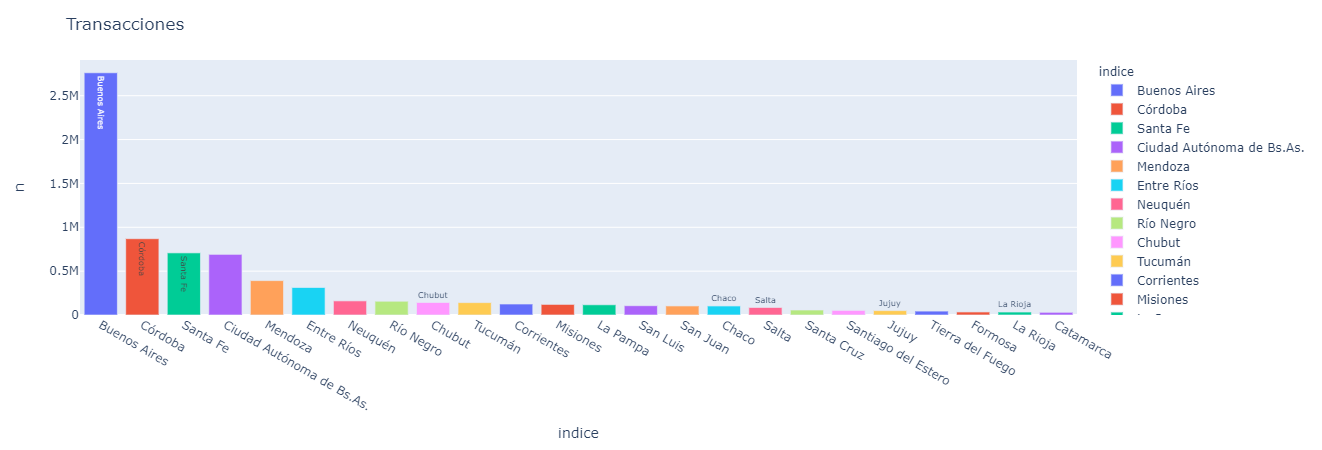

In [568]:
plot_hbar(df_group, 'indice', 'n',  'Transacciones')

In [569]:
df_mes = df.groupby('mes_año')[df.columns.drop(["tramite_fecha", 'año', 'mes_año'])].sum().reset_index()

In [570]:
'''
from datetime import datetime

año_string = "20200704"

dt   = datetime.strptime(año_string,'%Y%m%d').date()

print(dt)


min_seg = "02:00"

dt   = datetime.strptime(min_seg,'%M:%S').time()
        
        
print(dt)
'''

'\nfrom datetime import datetime\n\naño_string = "20200704"\n\ndt   = datetime.strptime(año_string,\'%Y%m%d\').date()\n\nprint(dt)\n\n\nmin_seg = "02:00"\n\ndt   = datetime.strptime(min_seg,\'%M:%S\').time()\n        \n        \nprint(dt)\n'

In [571]:
df_mes["mes_año"] = [d.to_timestamp() for d in df_mes["mes_año"].values]

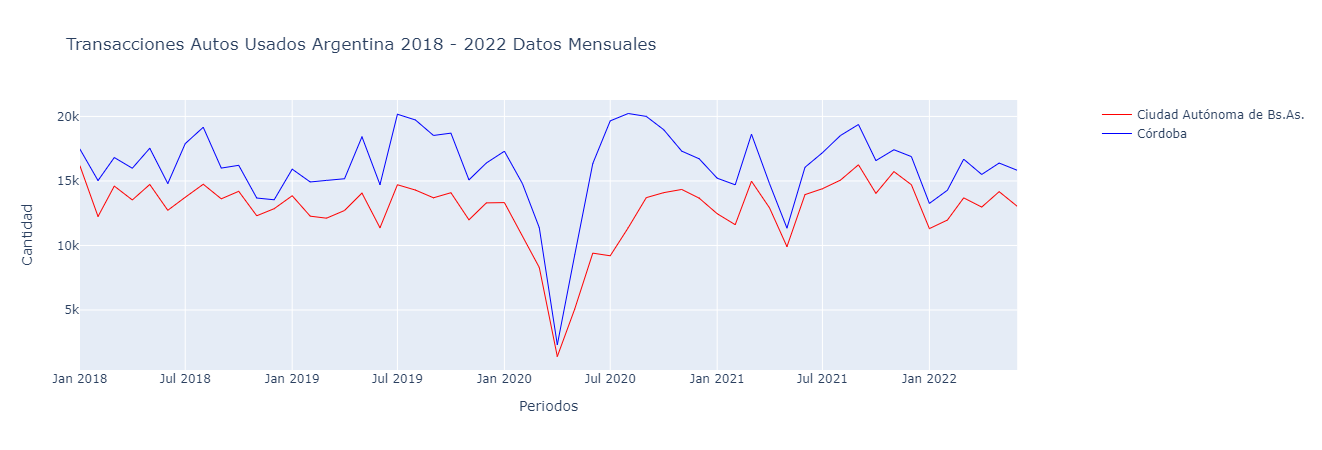

In [572]:
get_line_plot(df_mes, "mes_año", "Ciudad Autónoma de Bs.As.", "Córdoba", "Transacciones Autos Usados Argentina 2018 - 2022 Datos Mensuales")

In [573]:
df_mes["mes_año"] = pd.to_datetime(df_mes["mes_año"])
df_mes['año'] = pd.to_datetime(df_mes["mes_año"]).dt.year
df_mes.to_csv(r'cars.csv')

# Inicio del Modelo

Se eliminan todas las filas donde no hay transacciones

In [574]:
df_copy.head()

,Buenos Aires,Catamarca,Chaco,Chubut,Ciudad Autónoma de Bs.As.,Corrientes,Córdoba,Entre Ríos,Formosa,Jujuy,...,Salta,San Juan,San Luis,Santa Cruz,Santa Fe,Santiago del Estero,Tierra del Fuego,Tucumán,sum,tramite_fecha
tramite_fecha,,,,,,,,,,,,,,,,,,,,,
2018-01-02,2719,43,94,145,594,178,877,271,44,58,...,130,89,106,70,724,74,39,157,4666,2018-01-02
2018-01-03,2809,45,141,134,672,184,737,285,42,70,...,69,95,112,49,623,51,41,167,4577,2018-01-03
2018-01-04,2857,30,121,139,714,157,760,286,43,65,...,118,108,110,81,689,68,50,182,4773,2018-01-04
2018-01-05,2884,46,122,162,757,179,838,300,56,71,...,103,121,116,72,643,71,55,149,4912,2018-01-05
2018-01-08,2711,35,130,165,699,162,803,293,47,51,...,142,96,71,62,641,85,39,137,4682,2018-01-08


Desde el 19 de marzo al 22 de abril no contamos con datos. Si bien no es buena practica en series de tiempo alterar los datos en este caso, la pandemia ha alterado todas las series temporales.
Para este caso se va a tener en cuenta los promedios de los otros años para esas fechas asi podemos completar al serie temporal.

In [575]:
def get_dataframe(values, desde, hasta, years):
    data_frames = []
    for year in years:
        df_append = df_copy.loc[(df_copy['tramite_fecha'].dt.strftime('%m-%d') >= desde) & (df_copy['tramite_fecha'].dt.strftime('%m-%d') <= hasta) & (df_copy['tramite_fecha'].dt.strftime('%Y') == year)][values]
        data_frames.append(df_append)
    df_final_concat = pd.concat(data_frames, ignore_index=True)
    df_final_concat['month_day'] = df_final_concat['tramite_fecha'].dt.strftime('%m-%d')
    df_values = df_final_concat.groupby('month_day' ,as_index = False).mean().round(0)
    return df_values

start = '03-16'
end   = '05-15'

df_values = get_dataframe(['tramite_fecha','Ciudad Autónoma de Bs.As.' , 'Córdoba'], start, end, ['2018', '2019', '2021', '2022'])


In [576]:
df_values['month_day'] = df_values.apply(lambda x: '2020-' + str(x['month_day']), axis = 1)

df_values['month_day'] = pd.to_datetime(df_values['month_day'], format='%Y-%m-%d')

df_values.head()

,month_day,Ciudad Autónoma de Bs.As.,Córdoba
0,2020-03-16,670.0,834.0
1,2020-03-17,673.0,790.0
2,2020-03-18,654.0,817.0
3,2020-03-19,666.0,770.0
4,2020-03-20,670.0,771.0


Se agrupa por mes y dia, se saca el promedio y se agrega el año 2020:

In [577]:
df_values.rename(columns = {'month_day':'tramite_fecha'}, inplace = True)

In [578]:
df_values.index = df_values.tramite_fecha
df_values.head(3)

,tramite_fecha,Ciudad Autónoma de Bs.As.,Córdoba
tramite_fecha,,,
2020-03-16,2020-03-16,670.0,834.0
2020-03-17,2020-03-17,673.0,790.0
2020-03-18,2020-03-18,654.0,817.0


In [579]:
df_ts_1 = df_copy[['tramite_fecha','Ciudad Autónoma de Bs.As.' , 'Córdoba']]

df_ts_1.head(3)

,tramite_fecha,Ciudad Autónoma de Bs.As.,Córdoba
tramite_fecha,,,
2018-01-02,2018-01-02,594,877
2018-01-03,2018-01-03,672,737
2018-01-04,2018-01-04,714,760


In [580]:
df_ts_1.index =  pd.to_datetime(df_ts_1.index, format='%Y-%m-%d')

In [581]:
df_ts_1['tramite_fecha']   = df_ts_1.index
df_values['tramite_fecha'] = df_values.index

In [582]:
delete_index = list(df_values.index.unique())

In [583]:
df_ts = pd.concat([df_ts_1[~df_ts_1.index.isin(delete_index)], df_values], ignore_index = False)

In [584]:
df_ts

,tramite_fecha,Ciudad Autónoma de Bs.As.,Córdoba
tramite_fecha,,,
2018-01-02,2018-01-02,594.0,877.0
2018-01-03,2018-01-03,672.0,737.0
2018-01-04,2018-01-04,714.0,760.0
2018-01-05,2018-01-05,757.0,838.0
2018-01-08,2018-01-08,699.0,803.0
...,...,...,...
2020-05-11,2020-05-11,705.0,805.0
2020-05-12,2020-05-12,654.0,772.0
2020-05-13,2020-05-13,676.0,807.0


In [585]:
df_ts.to_csv('df_ts.csv')

In [586]:
df_ts.index.name = 'index'
df_ts.sort_values(by = 'tramite_fecha', inplace = True)

In [587]:
df_ts.head(5)

,tramite_fecha,Ciudad Autónoma de Bs.As.,Córdoba
index,,,
2018-01-02,2018-01-02,594.0,877.0
2018-01-03,2018-01-03,672.0,737.0
2018-01-04,2018-01-04,714.0,760.0
2018-01-05,2018-01-05,757.0,838.0
2018-01-08,2018-01-08,699.0,803.0


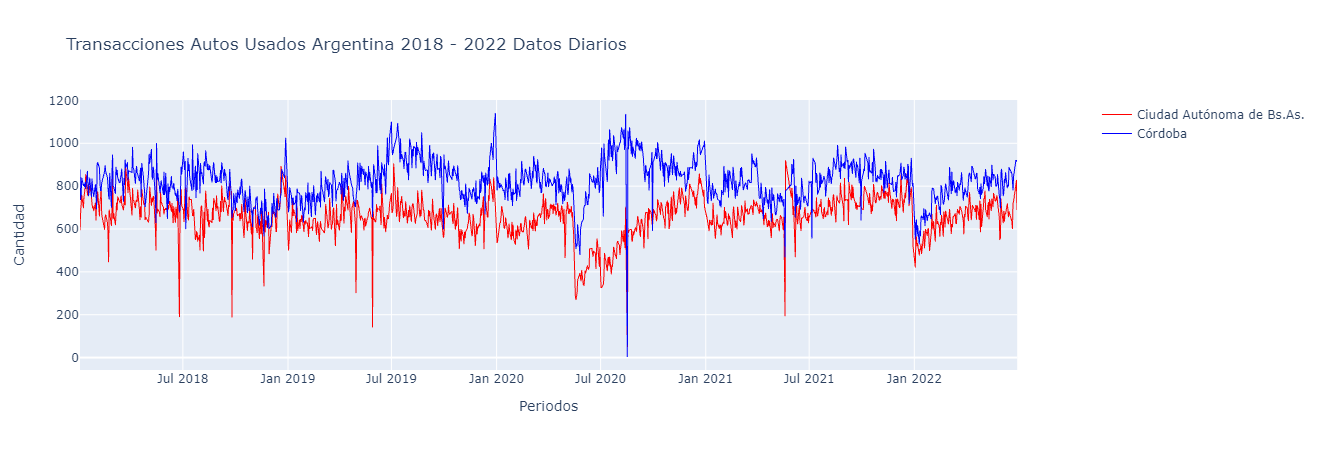

In [588]:
get_line_plot(df_ts, "tramite_fecha", "Ciudad Autónoma de Bs.As.", "Córdoba", "Transacciones Autos Usados Argentina 2018 - 2022 Datos Diarios")

In [589]:
df_ts = df_ts[df_ts['Córdoba']>= 40]

In [590]:
df_ts['mes_año'] = pd.to_datetime(df_ts['tramite_fecha']).dt.to_period('M')

df_mes = df_ts.groupby('mes_año')[df_ts.columns.drop(["tramite_fecha"])].sum().reset_index()

In [591]:
df_mes["mes_año"] = [d.to_timestamp() for d in df_mes["mes_año"].values]

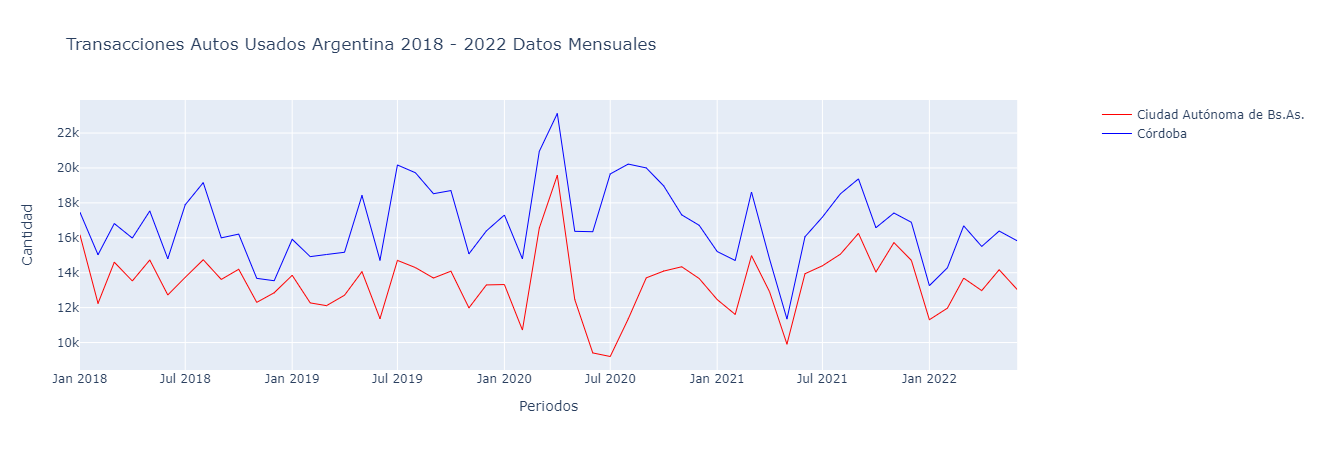

In [592]:
get_line_plot(df_mes, "mes_año", "Ciudad Autónoma de Bs.As.", "Córdoba", "Transacciones Autos Usados Argentina 2018 - 2022 Datos Mensuales")

In [593]:
df_ts.head(5)

,tramite_fecha,Ciudad Autónoma de Bs.As.,Córdoba,mes_año
index,,,,
2018-01-02,2018-01-02,594.0,877.0,2018-01
2018-01-03,2018-01-03,672.0,737.0,2018-01
2018-01-04,2018-01-04,714.0,760.0,2018-01
2018-01-05,2018-01-05,757.0,838.0,2018-01
2018-01-08,2018-01-08,699.0,803.0,2018-01


Eliminamos las columnas que no vamos a usar por ahora:

In [594]:
del df_ts['Ciudad Autónoma de Bs.As.']
del df_ts['tramite_fecha']

In [595]:
del df_ts['mes_año']

In [596]:
df_ts.head(5)

,Córdoba
index,
2018-01-02,877.0
2018-01-03,737.0
2018-01-04,760.0
2018-01-05,838.0
2018-01-08,803.0


Prueba de Dickey Fuller para verificar si un conjunto de datos proviene de un proceso estacionario o no. La prueba esta basada en un contraste de hipotesis.

Hipotesis Nula: La serie no es estacionaria

Hipotesis Alternativa: La serie es estacionaria


In [597]:
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns


def get_adfuller(value):
    if sts.adfuller(value)[0] > sts.adfuller(value)[4]['1%']:
        print('No rechazamos hipotesis nula, la serie NO ES estacionaria a un nivel de significacion del 1 % con un numero de retrasos de: ', sts.adfuller(value)[2])

    elif sts.adfuller(value)[0] > sts.adfuller(value)[4]['5%']:
        print('No rechazamos hipotesis nula, la serie NO ES estacionaria a un nivel de significacion del 5 % con un numero de retrasos de: ', sts.adfuller(value)[2])

    elif sts.adfuller(value)[0] > sts.adfuller(value)[4]['10%']:
        print('No rechazamos hipotesis nula, la serie NO ES estacionaria a un nivel de significacion del 10 % con un numero de retrasos de: ', sts.adfuller(value)[2])

    else: print('La serie ES estacionaria')
    return sts.adfuller(value)


get_adfuller(df_ts["Córdoba"])

La serie ES estacionaria


(-5.43044846701885,
 2.922522846240301e-06,
 4,
 1100,
 {'1%': -3.4363087505882794,
  '5%': -2.864171074710744,
  '10%': -2.5681708669421486},
 12077.366587372293)

Estacionalidad:

Sugiere que ciertas tendencias aparecerán de forma cíclica, por ejemplo, las temperaturas suben y bajan a lo largo del tiempo. La series se pueden descomponer bajo efecto tendencia donde podemos quitar un patrón sostenido en los datos, la estacional los efectos cíclicos y el residual el error entre los datos reales y el modelo que estamos ejecutando.

La descomposición clásica puede ser aditiva o multiplicativa, en la aditiva podemos suponer que en cualquier momento del tiempo el valor observado es la suma de la tendencia, el objeto estacional y el efecto residual para ese periodo.

La descomposición multiplicativa nos dice que la serie original es un producto de los tres efectos anteriories.

In [598]:
df_ts.sort_index(inplace=True)

In [599]:
df_ts.dropna(axis = 0, inplace=True)

In [600]:
df_ts.index

DatetimeIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
               '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11',
               '2018-01-12', '2018-01-15',
               ...
               '2022-06-14', '2022-06-15', '2022-06-16', '2022-06-21',
               '2022-06-22', '2022-06-23', '2022-06-24', '2022-06-28',
               '2022-06-29', '2022-06-30'],
              dtype='datetime64[ns]', name='index', length=1105, freq=None)

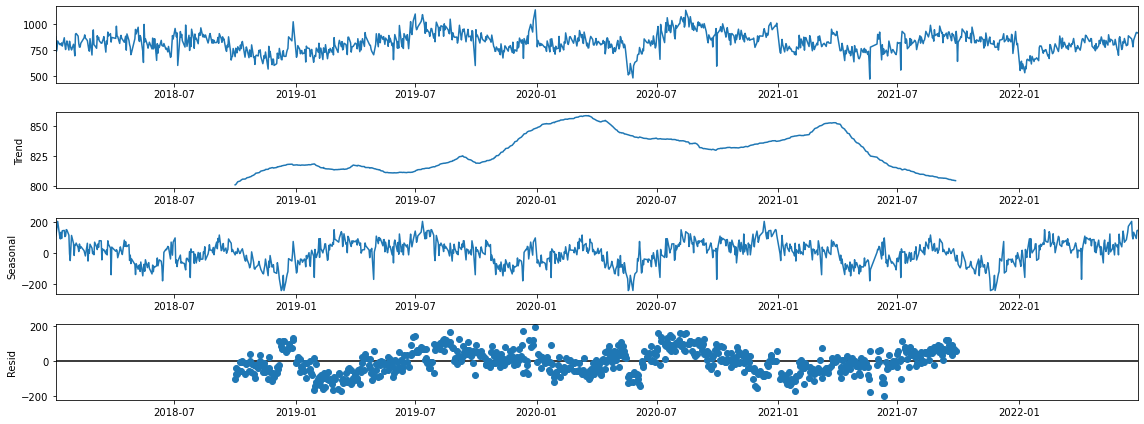

In [601]:
s_dec_additive = seasonal_decompose(df_ts,model = 'additive', freq = 365)
s_dec_additive.plot()
plt.show()

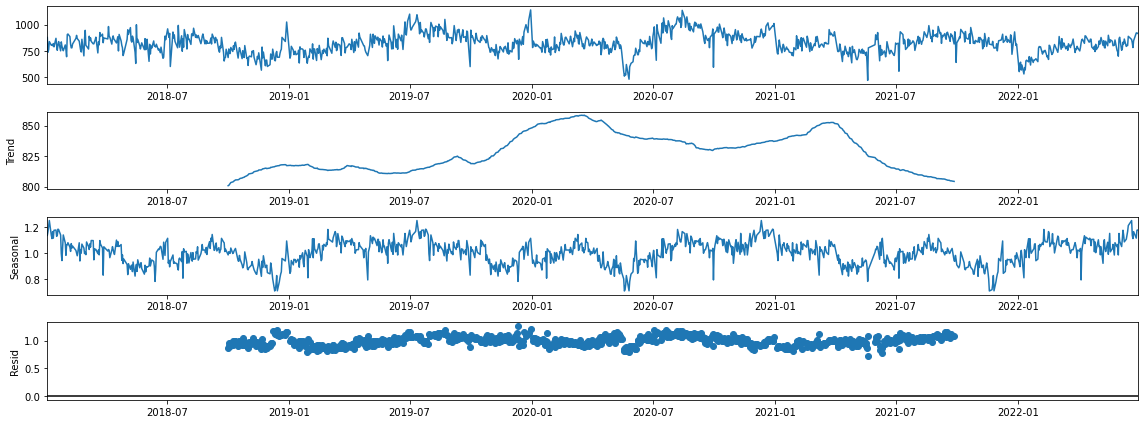

In [602]:
s_dec_additive = seasonal_decompose(df_ts,model = 'multiplicative', freq = 365)
s_dec_additive.plot()
plt.show()

ACF autocorrelacion

Los lags son los retrasos, por buenas practicas se usa 40, el zero false nos dice que si vamos a incluir el valor del periodo actual, le pusimos false porque  no es necesario incluirlo  ya que la correlacion  entre un valor y si mismo siempre sera 1

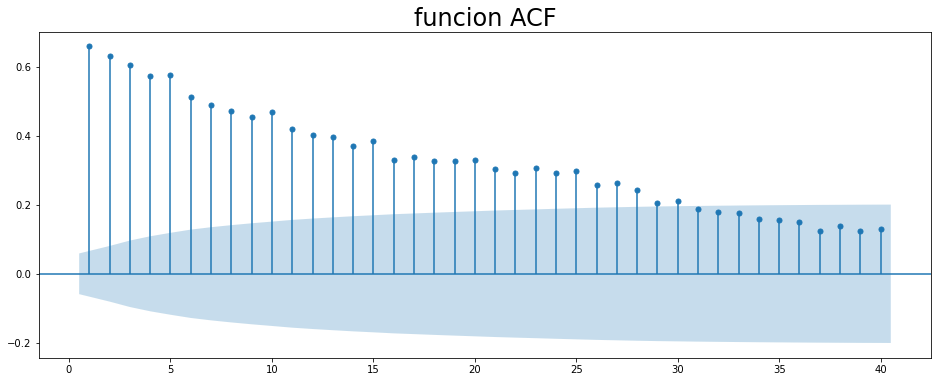

In [603]:
import statsmodels.graphics.tsaplots as sgt 

sgt.plot_acf(df_ts["Córdoba"], lags = 40, zero = False)
plt.title('funcion ACF', size = 24)
plt.show()

ACP autocorrelacion parcial

No considera los efectos intermedios sino los efectos de determinado periodo con el presente

Podemos observar que solo los primeros 5 elementos son significativos.

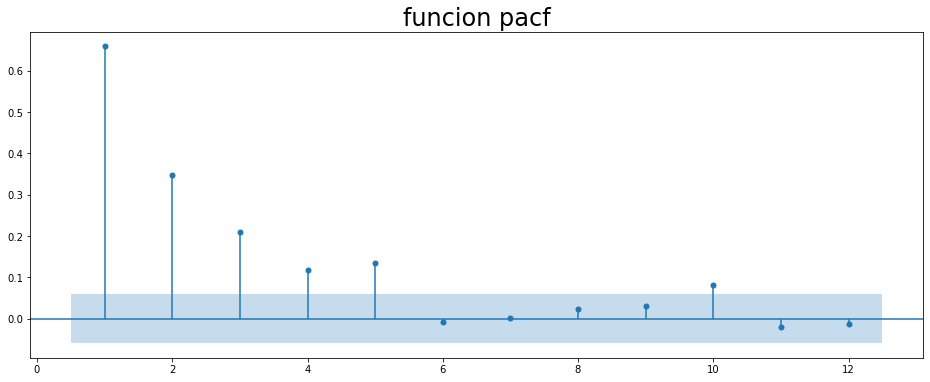

In [604]:
sgt.plot_pacf(df_ts["Córdoba"], lags = 12, zero = False, method= ('ols'))
plt.title('funcion pacf', size = 24)
plt.show()

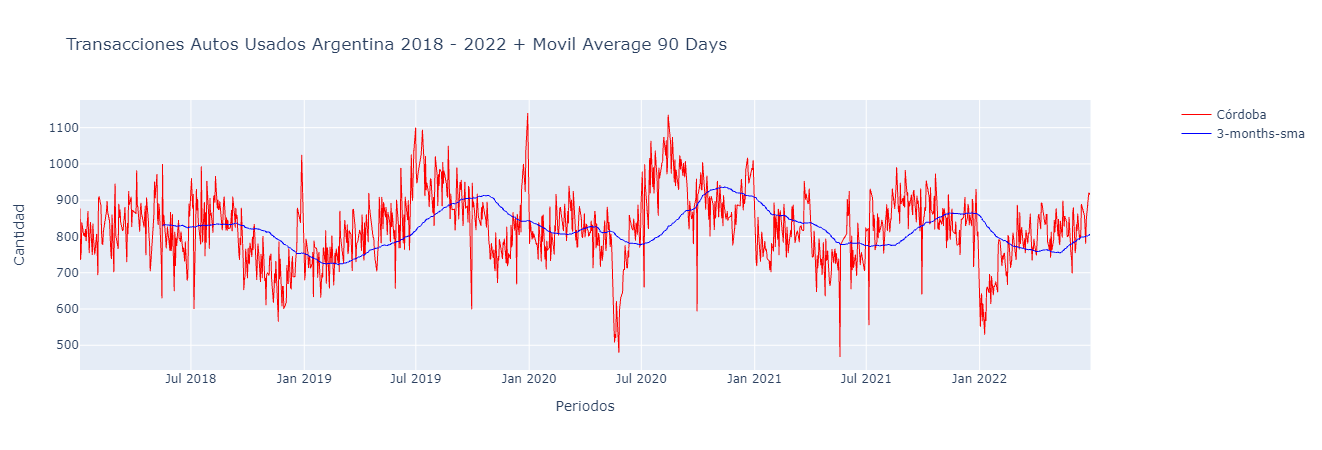

In [605]:
# Promedio movil simple

df_MA = df_ts.copy()

df_MA['tramite_fecha'] = df_MA.index

df_MA['3-months-sma'] = df_MA['Córdoba'].rolling(window=90).mean()


get_line_plot(df_MA, 'tramite_fecha', "Córdoba", "3-months-sma", "Transacciones Autos Usados Argentina 2018 - 2022 + Movil Average 90 Days")

# Modelo Autorregresivo


La autocorrelacion nos va a permitir desarrollar este modelo que se basa en tener en cuenta valores pasados. Es un modelo lineal donde los valores del periodo actual son la suma de resultados pasados multiplicados por un coeficiente mas un error.

El coeficiente siempre tiene que estar entre - 1 y 1. No puede ser superior en valor absoluto

El residuo van a ser diferencias impredecibles, si hay un patrón se va a identificar en las variables del modelo, el residuo es la diferencia entre el valor real y el estimado

Ejecutamos un modelo autorregresivo de orden 1 AR(1) 1 representa un retraso y el cero representa que no tenemos en cuenta valores resiudales

In [606]:
# LLR Test para comparar 2 modelos

# testeamos dos modelos construyendo una funcion que nos devolvera un p valor. la hipotesis nula nos dice que los dos modelos son significativamente similares y la alternativa es que son diferentes

# DF son los grados de libertad, se sacan entre la diferencia entre los coeficientes del modelo 1 y 2.

def LLR_test(mod_1, mod_2, DF=1):
    # Buscamos las logsimilitudes de ambos modelos
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

# Comparamos modelos:
# Si son significativamente diferentes me voy a quedar con el mas simple de todos, el de menos rezagos
# Probamos el test para mas rezagos

modelos_ar = 8
modelos_resultados = []
for i in range(1 , modelos_ar + 1):
    model = ARMA(df_ts['Córdoba'], order=(i,0))
    results = model.fit()
    print ("LLR test p-value = " + str(LLR_test(results, ARMA(df_ts['Córdoba'], order=(i + 1,0)).fit())), f'AR-{i} Vs AR-{i+1}')
    
model = ARMA(df_ts['Córdoba'], order=(4,0))
results_ar_4 = model.fit()
# Nos quedamos con el modelo 4 ya que el sigueinte modelo no es significativo. incluir los precios de una semana atras nos puede dar buenos resultados. (dias habiles)

LLR test p-value = 0.0 AR-1 Vs AR-2
LLR test p-value = 0.0 AR-2 Vs AR-3
LLR test p-value = 0.0 AR-3 Vs AR-4
LLR test p-value = 0.0 AR-4 Vs AR-5
LLR test p-value = 0.769 AR-5 Vs AR-6
LLR test p-value = 0.947 AR-6 Vs AR-7
LLR test p-value = 0.418 AR-7 Vs AR-8
LLR test p-value = 0.312 AR-8 Vs AR-9


Analizamos los residuos del modelo 5
tienen que ser ruido blanco, no deben tener autocorrelacion y deben ser estacionarios

In [607]:
df_ts['res_price'] = results_ar_4.resid
sts.adfuller(df_ts.res_price)[1]

2.7728679229026723e-27

autocorrelacion: la mayoria cae en area azul, no hay autocorrelacion

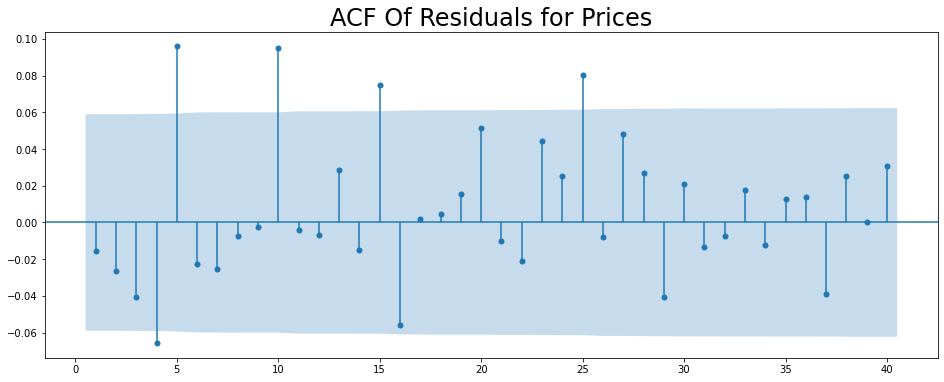

In [608]:
sgt.plot_acf(df_ts.res_price, zero = False, lags = 40)
plt.title("ACF Of Residuals for Prices",size=24)
plt.show()

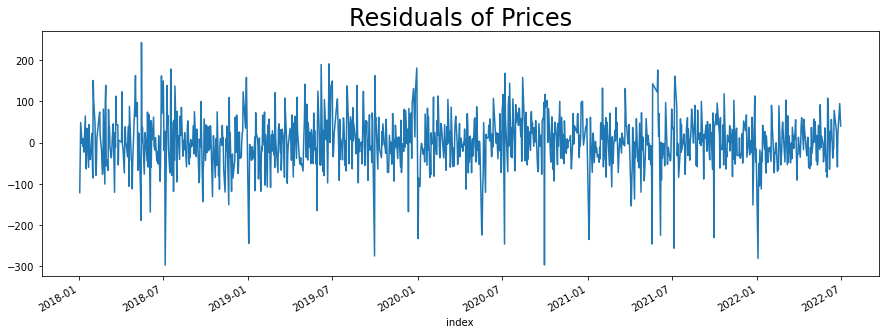

In [609]:
df_ts.res_price[1:].plot(figsize=(15,5))
plt.title("Residuals of Prices",size=24)
plt.show()

In [610]:
df = df_ts[df_ts.index.year.isin(['2018','2019','2020','2021','2022'])]

In [611]:
size_test = 5 * 20
train, test = df[['Córdoba']][0:-size_test], df[['Córdoba']][-size_test:]


model_aarima = pm.auto_arima(train['Córdoba'],
                        m=5, seasonal=True,
                      start_p=0, start_q=0, max_order=1, test='adf',error_action='ignore',  
                           suppress_warnings=True,
                      stepwise=True, trace=True)

print(model_aarima.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[5] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(0,0,0)(0,0,0)[5] intercept   : AIC=12043.133, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[5] intercept   : AIC=11422.876, Time=0.80 sec
 ARIMA(0,0,1)(0,0,1)[5] intercept   : AIC=11600.606, Time=0.51 sec
 ARIMA(0,0,0)(0,0,0)[5]             : AIC=16361.272, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[5] intercept   : AIC=11467.665, Time=0.09 sec
 ARIMA(1,0,0)(2,0,0)[5] intercept   : AIC=11401.366, Time=2.68 sec
 ARIMA(1,0,0)(2,0,1)[5] intercept   : AIC=12193.024, Time=1.34 sec
 ARIMA(1,0,0)(1,0,1)[5] intercept   : AIC=11421.750, Time=0.90 sec
 ARIMA(0,0,0)(2,0,0)[5] intercept   : AIC=12025.553, Time=1.34 sec
 ARIMA(2,0,0)(2,0,0)[5] intercept   : AIC=11306.310, Time=1.96 sec
 ARIMA(2,0,0)(1,0,0)[5] intercept   : AIC=11319.421, Time=0.94 sec
 ARIMA(2,0,0)(2,0,1)[5] intercept   : AIC=12086.075, Time=1.80 sec
 ARIMA(2,0,0)(1,0,1)[5] intercept   : AIC=11316.945, Time=1.12 sec
 ARIMA(3,0,0)(2,0,0)[5] i

In [612]:
train[train==np.inf]=np.nan
test[test==np.inf]=np.nan

train = train.fillna(method='ffill')
test = test.fillna(method='ffill')

In [613]:
model_aarima.fit(train)

ARIMA(order=(3, 0, 0), scoring_args={}, seasonal_order=(2, 0, 0, 5),
      suppress_warnings=True)

In [614]:
forecast = model_aarima.predict(n_periods = size_test, return_conf_int=True)

In [615]:
forecast_df = pd.DataFrame(forecast[0],index = test.index,columns=['Prediction'])

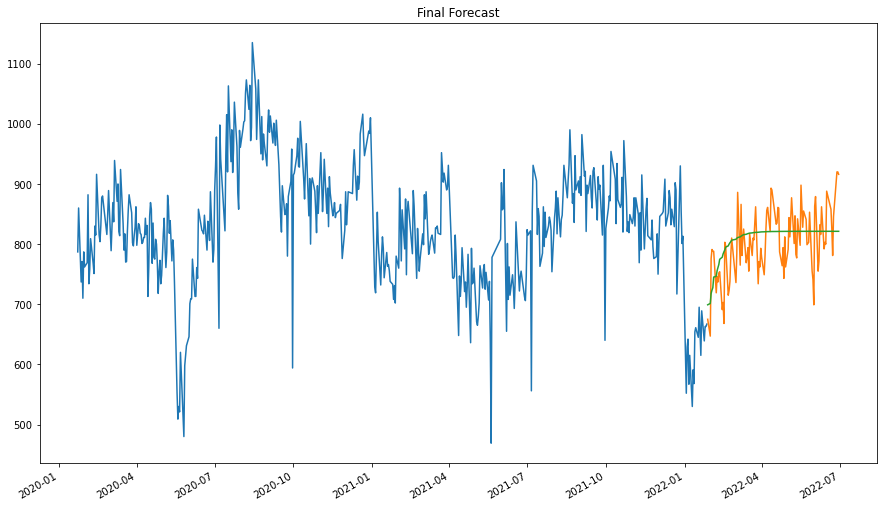

In [616]:
fig, ax = plt.subplots(figsize=(15,9))
ax.plot(train[500:])
ax.plot(test)
ax.plot(forecast_df)
ax.set_title("Final Forecast")
ax.figure.autofmt_xdate()
plt.show()

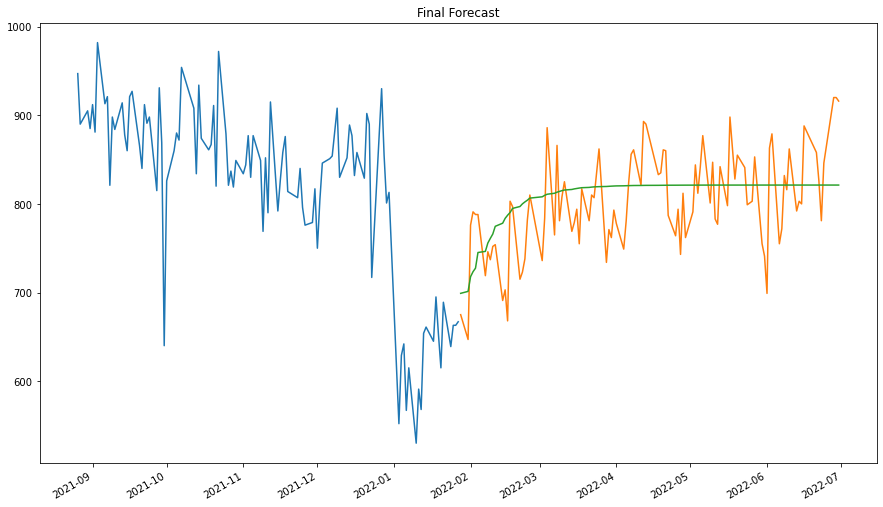

In [617]:
fig, ax = plt.subplots(figsize=(15,9))
ax.plot(train[900:])
ax.plot(test)
ax.plot(forecast_df)
ax.set_title("Final Forecast")
ax.figure.autofmt_xdate()
plt.show()

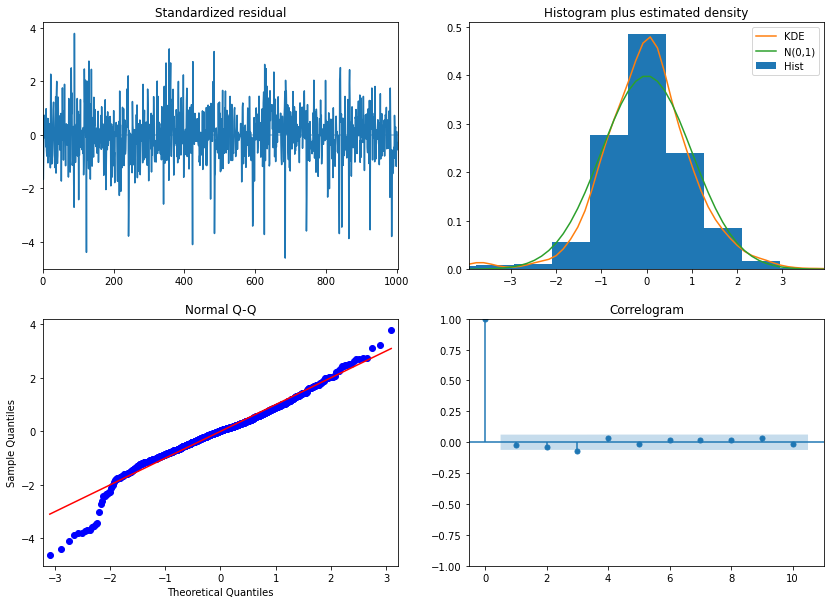

In [618]:
model_aarima.plot_diagnostics(figsize=(14,10))
plt.show()